In [181]:
import numpy as np
import matplotlib.pyplot as plt
from pydgrid.pydgrid import grid
from pydgrid.pf import pf_eval
from pydgrid.plot_bokeh import plot_results

In [228]:
%matplotlib notebook

## CIGRE LV European System

In [182]:
V_n_kV = 400.0/np.sqrt(3)/1e3

data = {
"buses":[
		{"bus": "R1",  "pos_x":   0, "pos_y":    0, "units": "m", "U_kV": 0.4},
		{"bus": "R2",  "pos_x":   0, "pos_y":  -35, "units": "m", "U_kV": 0.4},
		{"bus": "R10", "pos_x":   0, "pos_y": -315, "units": "m", "U_kV": 0.4}
        ],
"lines":[
        {"bus_j": "R1",  "bus_k":  "R2",  "code": "UG1_luna", "m":  35.0 },
        {"bus_j": "R2",  "bus_k": "R10",  "code": "UG1_luna", "m": 280.0 }    
        ],
"shunts":[
        {"bus":  "R1" , "R": 0.001, "X": 0.0, "bus_nodes": [4,0]},
        {"bus": "R10" , "R": 0.001, "X": 0.0, "bus_nodes": [4,0]},
        ],
"grid_formers":[
        {"bus":  "R1","bus_nodes": [1, 2, 3],
         "deg": [0, -120, -240], "kV": [V_n_kV, V_n_kV, V_n_kV]},
        {"bus": "R10","bus_nodes": [1, 2, 3],
         "deg": [0, -120, -240], "kV": [V_n_kV, V_n_kV, V_n_kV]}
        ],
"loads":[
        {"bus": "R2", "kVA": 20.0, "pf": 0.95, "type":"1P+N", "bus_nodes": [1,4]},
        {"bus": "R2", "kVA": 20.0, "pf": 0.95, "type":"1P+N", "bus_nodes": [2,4]},
        {"bus": "R2", "kVA": 20.0, "pf": 0.95, "type":"1P+N", "bus_nodes": [3,4]}
        ],
"line_codes":
        {"UG1":
            {"R":[[ 0.211,  0.049,  0.049,  0.049],
                  [ 0.049,  0.211,  0.049,  0.049],
                  [ 0.049,  0.049,  0.211,  0.049],
                  [ 0.049,  0.049,  0.049,  0.211]],
             "X":[[ 0.747,  0.673,  0.651,  0.673],
                  [ 0.673,  0.747,  0.673,  0.651],
                  [ 0.651,  0.673,  0.747,  0.673],
                  [ 0.673,  0.651,  0.673,  0.747]]
            },
        "UG3":
            {"R":[[ 0.871,  0.049,  0.049,  0.049],
                  [ 0.049,  0.871,  0.049,  0.049],
                  [ 0.049,  0.049,  0.871,  0.049],
                  [ 0.049,  0.049,  0.049,  0.871]],
             "X":[[ 0.797,  0.719,  0.697,  0.719],
                  [ 0.719,  0.797,  0.719,  0.697],
                  [ 0.697,  0.719,  0.797,  0.719],
                  [ 0.719,  0.697,  0.719,  0.797]]
            }
        }
}

In [153]:
grid_1 = grid()
grid_1.read(data)  # Load data
grid_1.pf()  # solve power flow
p=plot_results(grid_1)

In [154]:
nodes_3ph_R1 = [0,1,2]
nodes_3ph_R10 = [3,4,5]
gen2nodes = np.array([nodes_3ph_R1,nodes_3ph_R10])
gen2nodes

array([[0, 1, 2],
       [3, 4, 5]])

In [271]:
grid_1.read(data)  # Load data
grid_1.pf()  # solve power flow
S_n = 20.0e3
V_n = 231.0
N = 1000 # number of iterations
T = np.zeros((N))
V = np.zeros((N,6))+0j
I = np.zeros((N,6))+0j
I_ph_list = []
DVp = np.zeros((2))
DVang = np.zeros((2))
Dt = 0.01
T_g = 1.0
Dt_2nd = 1.0
t_2nd = 0.0
DV_2nd = 0.0
DV_2ndI = 0.0
T_i = 1.0
DV_2nd_ref = 0.0
for it in range(N):
    t = Dt*it
    T[it] = t
    if t > t_2nd + Dt_2nd:
        V_ph = grid_1.params_pf[0].V_node[gen2nodes[g,:]]
        V_m1   = np.abs(V_ph[0])
        DV_2nd = V_n - V_m1
        DV_2ndI += Dt_2nd*1/T_i*(V_n - V_m1)
        DV_2nd_ref = (0.1*DV_2nd + DV_2ndI)
        t_2nd = t
    
    # for each generator
    for g in [0,1]:
        

        # current volatges and currents
        V_ph = grid_1.params_pf[0].V_node[gen2nodes[g,:]]
        V_m   = np.abs(V_ph)
        V_ang = np.angle(V_ph)
        I_ph = grid_1.params_pf[0].I_node[gen2nodes[g,:]]

        V[it,3*g:(3+3*g)] = V_ph[:,0]
        I[it,3*g:(3+3*g)] = I_ph[:,0]
        
        # current powers
        S_ph = V_ph*np.conj(I_ph)
        S_t = np.sum(S_ph)
        
        # opposite droop with powers
        DV = 0.1*S_t.real/S_n*V_n
        DVp[g] += Dt*1/T_g*(DV - DVp[g])
        V_m_ref = V_n - DVp[g] + DV_2nd_ref
        
        Dang = 0.001*S_t.imag/S_n
        DVang[g] += Dt*1/T_g*(Dang - DVang[g])
        V_ang_ref = V_ang + DVang[g]
        
        grid_1.params_pf[0].V_node[gen2nodes[g,:]] = V_m_ref*np.exp(1j*V_ang_ref)
        
        
        pf_eval(grid_1.params_pf)
        
       


         
           
grid_1.get_v()  
grid_1.get_i() 
p1=plot_results(grid_1)

<IPython.core.display.Javascript object>


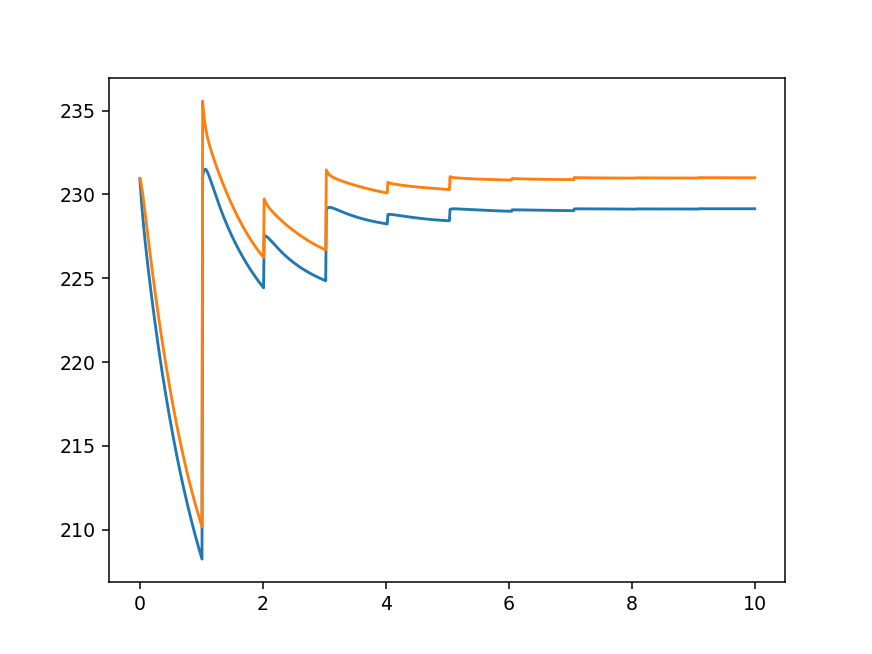

In [272]:
fig, axes = plt.subplots()

axes.plot(T,np.abs(V[:,0]))
axes.plot(T,np.abs(V[:,3]))

In [268]:
I_ph_list

[]

In [223]:
V.shape

(1000, 6)

In [189]:
grid_1.nodes

['R1.1',
 'R1.2',
 'R1.3',
 'R10.1',
 'R10.2',
 'R10.3',
 'R2.1',
 'R2.4',
 'R2.2',
 'R2.3',
 'R1.4',
 'R10.4']